# Part 2: Identify the three providers that are least like other providers and the three regions that are least similar to other regionss

In [3]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
# Step 1: Connect to SQL Server
# Define connection parameters
server = 'DESKTOP-DGDUOBT\SQLEXPRESS'  
database = 'MedicareAnalysis'
username = ''  
password = ''  
driver = '{ODBC Driver 17 for SQL Server}'   

try:
    conn = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes')
    print("Connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful!


In [5]:
Provider_Charge_In = pd.read_sql_query("SELECT * FROM Provider_Charge_Inpatient_DRG", conn)
Provider_Charge_Out = pd.read_sql_query("SELECT * FROM Provider_Charge_Outpatient_APC", conn)

C:\Users\HP\AppData\Local\Temp\ipykernel_5452\3959159060.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Provider_Charge_In = pd.read_sql_query("SELECT * FROM Provider_Charge_Inpatient_DRG", conn)
C:\Users\HP\AppData\Local\Temp\ipykernel_5452\3959159060.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Provider_Charge_Out = pd.read_sql_query("SELECT * FROM Provider_Charge_Outpatient_APC", conn)


In [6]:
Provider_Charge_In.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   DRG_Definition             163065 non-null  object 
 1   Provider_Id                163065 non-null  int64  
 2   Provider_Name              163065 non-null  object 
 3   Provider_Street_Address    163065 non-null  object 
 4   Provider_City              163065 non-null  object 
 5   Provider_State             163065 non-null  object 
 6   Provider_Zip_Code          163065 non-null  int64  
 7   Hospital_Referral_Region   163065 non-null  object 
 8   Total_Discharges           163065 non-null  int64  
 9   Average_Covered_Charges    163065 non-null  float64
 10  Average_Total_Payments     163065 non-null  float64
 11  Average_Medicare_Payments  163065 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 14.9+ MB


In [5]:
Provider_Charge_Out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43372 entries, 0 to 43371
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   APC                                       43372 non-null  object 
 1   Provider_Id                               43372 non-null  int64  
 2   Provider_Name                             43372 non-null  object 
 3   Provider_Street_Address                   43372 non-null  object 
 4   Provider_City                             43372 non-null  object 
 5   Provider_State                            43372 non-null  object 
 6   Provider_Zip_Code                         43372 non-null  int64  
 7   Hospital_Referral_Region_HRR_Description  43372 non-null  object 
 8   Outpatient_Services                       43372 non-null  int64  
 9   Average_Estimated_Submitted_Charges       43372 non-null  float64
 10  Average_Total_Payments            

## Part 2A: Least Similar Providers

### OVERALL (In+Out)

In [6]:
print(Provider_Charge_In.columns)
print(Provider_Charge_Out.columns)

Index(['DRG_Definition', 'Provider_Id', 'Provider_Name',
       'Provider_Street_Address', 'Provider_City', 'Provider_State',
       'Provider_Zip_Code', 'Hospital_Referral_Region', 'Total_Discharges',
       'Average_Covered_Charges', 'Average_Total_Payments',
       'Average_Medicare_Payments'],
      dtype='object')
Index(['APC', 'Provider_Id', 'Provider_Name', 'Provider_Street_Address',
       'Provider_City', 'Provider_State', 'Provider_Zip_Code',
       'Hospital_Referral_Region_HRR_Description', 'Outpatient_Services',
       'Average_Estimated_Submitted_Charges', 'Average_Total_Payments'],
      dtype='object')


In [7]:
# Standardize column names
Provider_Charge_In = Provider_Charge_In.rename(columns={
    'DRG_Definition': 'Procedure',
    'Hospital_Referral_Region': 'HRR_Description',
    'Total_Discharges': 'Total_Services',
    'Average_Covered_Charges': 'Average_Charges'
})

Provider_Charge_Out = Provider_Charge_Out.rename(columns={
    'APC': 'Procedure',
    'Hospital_Referral_Region_HRR_Description': 'HRR_Description',
    'Outpatient_Services': 'Total_Services',
    'Average_Estimated_Submitted_Charges': 'Average_Charges',
    'Average_Total_Payments': 'Average_Medicare_Payments'  # Treat as Medicare Payments
})

# Select Common Columns
inpatient_selected = Provider_Charge_In[['Provider_Id', 'Provider_Name', 'HRR_Description', 'Total_Services', 'Average_Charges', 'Average_Medicare_Payments']]
outpatient_selected = Provider_Charge_Out[['Provider_Id', 'Provider_Name', 'HRR_Description', 'Total_Services', 'Average_Charges', 'Average_Medicare_Payments']]

# Append Inpatient & Outpatient Data
combined_provider_data = pd.concat([inpatient_selected, outpatient_selected], ignore_index=True)

# Standardize Data
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined_provider_data[['Total_Services', 'Average_Charges', 'Average_Medicare_Payments']])

#### 1. Elbow Method

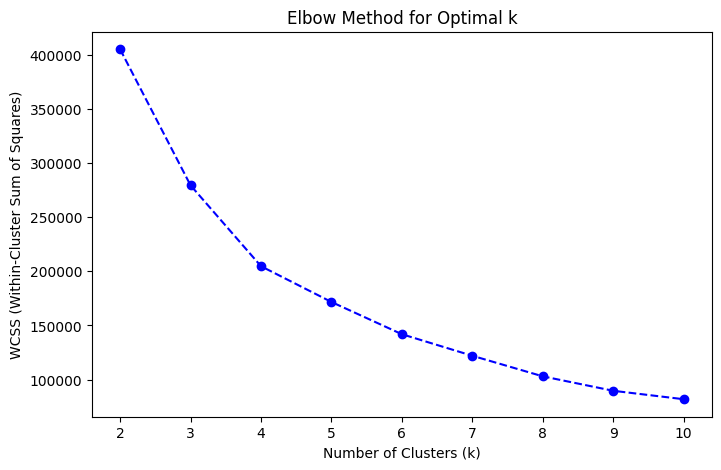

In [8]:
# Find optimal k using Elbow Method
wcss = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(combined_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

#### 2. Silhouette Method

In [29]:
from sklearn.metrics import silhouette_score

# Find optimal k using Silhouette Score
silhouette_scores = []

for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(combined_scaled)
    score = silhouette_score(combined_scaled, cluster_labels)
    silhouette_scores.append(score)

silhouette_scores


[np.float64(0.6666513763968595),
 np.float64(0.6724537591164383),
 np.float64(0.5190969239088413),
 np.float64(0.5219796476655773),
 np.float64(0.40987634097851633),
 np.float64(0.43285764745151317),
 np.float64(0.40889410590839814),
 np.float64(0.4493568100038923),
 np.float64(0.45111624521537297)]

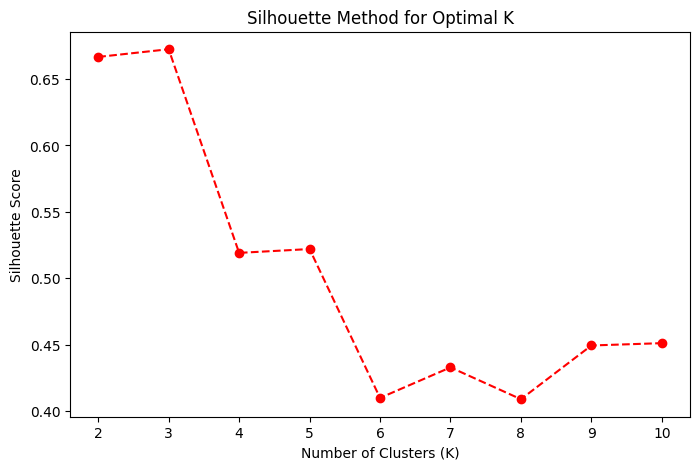

In [30]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal K")
plt.show()

Top 3 Least Similar Providers (Overall):
                          Provider_Name  Distance_From_Center
198413                 CLEVELAND CLINIC            143.918156
200864  SCOTT & WHITE MEMORIAL HOSPITAL            102.267890
199609                EVANSTON HOSPITAL             91.182990


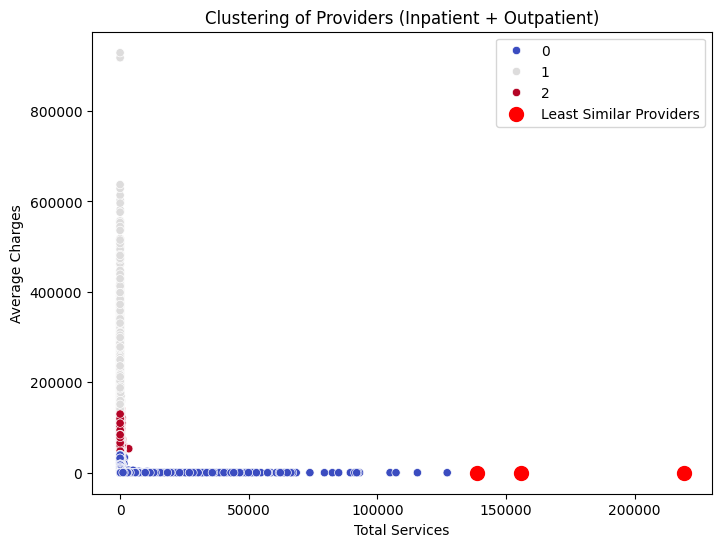

In [31]:

# Apply K-Means Clustering
kmeans_combined = KMeans(n_clusters=3, random_state=42)
combined_provider_data['Cluster'] = kmeans_combined.fit_predict(combined_scaled)

# Compute Distance from Cluster Centers
distances_combined = np.min(cdist(combined_scaled, kmeans_combined.cluster_centers_, 'euclidean'), axis=1)
combined_provider_data['Distance_From_Center'] = distances_combined

# Get Top 3 Least Similar Providers
least_similar_providers = combined_provider_data.nlargest(3, 'Distance_From_Center')[['Provider_Name', 'Distance_From_Center']]

# Print Results
print("Top 3 Least Similar Providers (Overall):")
print(least_similar_providers)

# Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=combined_provider_data['Total_Services'], 
                y=combined_provider_data['Average_Charges'], 
                hue=combined_provider_data['Cluster'], palette='coolwarm')
plt.scatter(combined_provider_data.nlargest(3, 'Distance_From_Center')['Total_Services'], 
            combined_provider_data.nlargest(3, 'Distance_From_Center')['Average_Charges'], 
            color='red', label='Least Similar Providers', s=100)
plt.xlabel("Total Services")
plt.ylabel("Average Charges")
plt.legend()
plt.title("Clustering of Providers (Inpatient + Outpatient)")
plt.show()


## Part 2B: Least Similar Regions

### OVERALL (In+Out)

In [14]:
# Group by Region
region_combined_data = combined_provider_data.groupby('HRR_Description').agg({
    'Total_Services': 'sum',
    'Average_Charges': 'mean',
    'Average_Medicare_Payments': 'mean'
}).reset_index()

# Standardize Data
region_combined_scaled = scaler.fit_transform(region_combined_data.iloc[:, 1:])

#### 1. Elbow Method

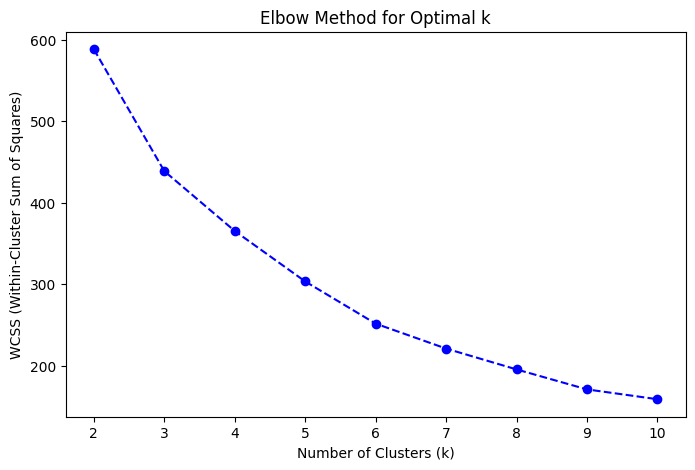

In [15]:
# Find optimal k using Elbow Method
wcss = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(region_combined_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

#### 2. Silhouette Method

In [37]:
from sklearn.metrics import silhouette_score

# Find optimal k using Silhouette Score
silhouette_scores = []

for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(region_combined_scaled)
    score = silhouette_score(region_combined_scaled, cluster_labels)
    silhouette_scores.append(score)

silhouette_scores

[np.float64(0.5309286986602222),
 np.float64(0.4876103563354046),
 np.float64(0.45251537528592556),
 np.float64(0.34697653488081115),
 np.float64(0.3353240624391968),
 np.float64(0.34687607887510225),
 np.float64(0.31943632249386794),
 np.float64(0.32743878906629725),
 np.float64(0.2982760473359799)]

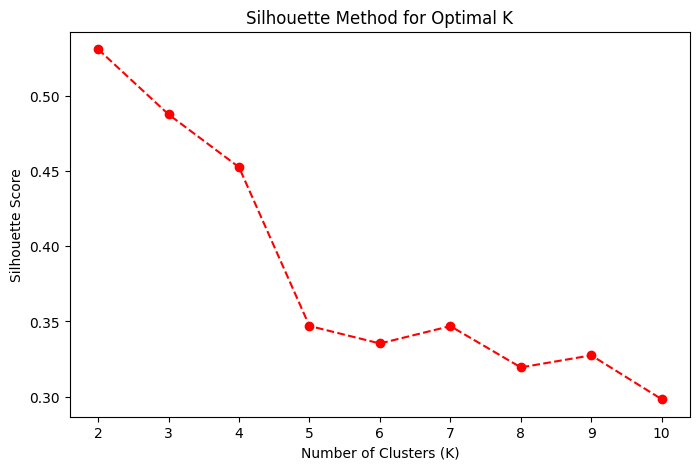

In [26]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal K")
plt.show()

Top 3 Least Similar Regions (Overall):
    HRR_Description  Distance_From_Center
127     MA - Boston             10.266992
210  OH - Cleveland              4.995462
203  NY - Manhattan              4.246907


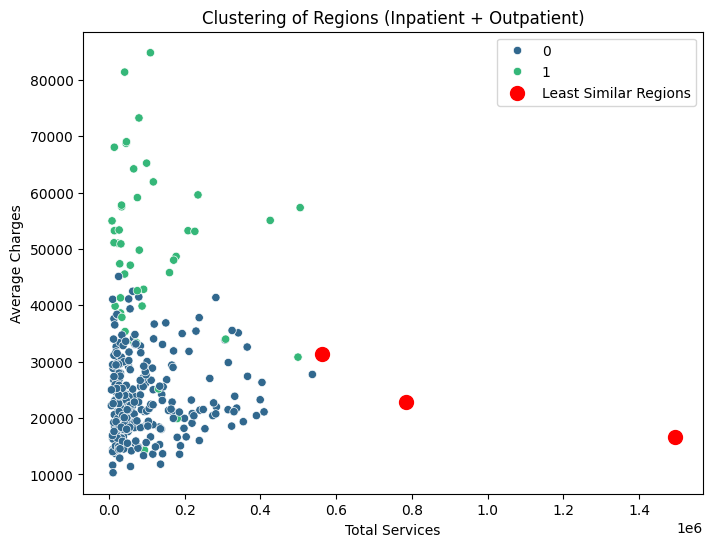

In [38]:

# Apply K-Means Clustering
kmeans_region_combined = KMeans(n_clusters=2, random_state=42)
region_combined_data['Cluster'] = kmeans_region_combined.fit_predict(region_combined_scaled)

# Compute Distance from Cluster Centers
distances_region_combined = np.min(cdist(region_combined_scaled, kmeans_region_combined.cluster_centers_, 'euclidean'), axis=1)
region_combined_data['Distance_From_Center'] = distances_region_combined

# Get Top 3 Least Similar Regions
least_similar_regions = region_combined_data.nlargest(3, 'Distance_From_Center')[['HRR_Description', 'Distance_From_Center']]

# Print Results
print("Top 3 Least Similar Regions (Overall):")
print(least_similar_regions)

# Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=region_combined_data['Total_Services'], 
                y=region_combined_data['Average_Charges'], 
                hue=region_combined_data['Cluster'], palette='viridis')
plt.scatter(region_combined_data.nlargest(3, 'Distance_From_Center')['Total_Services'], 
            region_combined_data.nlargest(3, 'Distance_From_Center')['Average_Charges'], 
            color='red', label='Least Similar Regions', s=100)
plt.xlabel("Total Services")
plt.ylabel("Average Charges")
plt.legend()
plt.title("Clustering of Regions (Inpatient + Outpatient)")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(region_combined_scaled)

    # Compute silhouette score only if more than 1 cluster
    if len(set(labels)) > 1:
        score = silhouette_score(region_combined_scaled, labels, sample_size=500)  # Speed boost 🚀
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Invalid cluster scenario

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal K")
plt.show()
